Imports necessary libraries

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Changed seed value
np.random.seed(42)

Neural Network Class Definition

In [98]:
class MultiClassNN(object):
    def __init__(self):
        input_neurons = 2
        hidden_layer_1_size = 16
        hidden_layer_2_size = 8
        hidden_layer_3_size = 4
        output_neurons = 5

        self.learning_rate = 0.01

        self.weights1 = np.random.randn(input_neurons, hidden_layer_1_size)
        self.weights2 = np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
        self.weights3 = np.random.randn(hidden_layer_2_size, hidden_layer_3_size)
        self.weights4 = np.random.randn(hidden_layer_3_size, output_neurons)

        self.biases1 = np.zeros((1, hidden_layer_1_size))
        self.biases2 = np.zeros((1, hidden_layer_2_size))
        self.biases3 = np.zeros((1, hidden_layer_3_size))
        self.biases4 = np.zeros((1, output_neurons))

    # ReLU activation
    def relu_activation(self, vector_x, derivative=False):
        if derivative:
            return (vector_x > 0).astype(float)
        return np.maximum(0, vector_x)

    # Softmax output
    def calculate_softmax(self, vector_x):
        exps = np.exp(vector_x - np.max(vector_x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    # Feedforward
    def forward_pass(self, input_features):
        self.layer1_output = self.relu_activation(np.dot(input_features, self.weights1) + self.biases1)
        self.layer2_output = self.relu_activation(np.dot(self.layer1_output, self.weights2) + self.biases2)
        self.layer3_output = self.relu_activation(np.dot(self.layer2_output, self.weights3) + self.biases3)
        self.final_output = self.calculate_softmax(np.dot(self.layer3_output, self.weights4) + self.biases4)
        return self.final_output

    # Backpropagation
    def back_propagate(self, input_features, one_hot_labels, predictions):
        m = input_features.shape[0]

        # Output layer error
        error_delta4 = (predictions - one_hot_labels) / m
        grad_weights4 = np.dot(self.layer3_output.T, error_delta4)
        grad_biases4 = np.sum(error_delta4, axis=0, keepdims=True)

        # Layer 3
        error_delta3 = np.dot(error_delta4, self.weights4.T) * self.relu_activation(self.layer3_output, derivative=True)
        grad_weights3 = np.dot(self.layer2_output.T, error_delta3)
        grad_biases3 = np.sum(error_delta3, axis=0, keepdims=True)

        # Layer 2
        error_delta2 = np.dot(error_delta3, self.weights3.T) * self.relu_activation(self.layer2_output, derivative=True)
        grad_weights2 = np.dot(self.layer1_output.T, error_delta2)
        grad_biases2 = np.sum(error_delta2, axis=0, keepdims=True)

        # Layer 1
        error_delta1 = np.dot(error_delta2, self.weights2.T) * self.relu_activation(self.layer1_output, derivative=True)
        grad_weights1 = np.dot(input_features.T, error_delta1)
        grad_biases1 = np.sum(error_delta1, axis=0, keepdims=True)


        # Update weights
        self.weights4 -= self.learning_rate * grad_weights4
        self.biases4 -= self.learning_rate * grad_biases4
        self.weights3 -= self.learning_rate * grad_weights3
        self.biases3 -= self.learning_rate * grad_biases3
        self.weights2 -= self.learning_rate * grad_weights2
        self.biases2 -= self.learning_rate * grad_biases2
        self.weights1 -= self.learning_rate * grad_weights1
        self.biases1 -= self.learning_rate * grad_biases1


    # Train
    def train(self, input_features, one_hot_labels):
        predictions = self.forward_pass(input_features)
        self.back_propagate(input_features, one_hot_labels, predictions)

    # Predict
    def predict(self, input_features):
        predictions = self.forward_pass(input_features)
        return np.argmax(predictions, axis=1)

Generate Synthetic Dataset (5 Classes)


In [99]:
num_classes = 5
class_samples = 200
total_samples = num_classes * class_samples

class_centers = np.array([
    [-5.0,  5.0],  # Top Left
    [ 5.0,  5.0],  # Top Right
    [ 0.0,  0.0],  # Center
    [-5.0, -5.0],  # Bottom Left
    [ 5.0, -5.0]   # Bottom Right
])

input_data = np.zeros((total_samples, 2))
labels = np.zeros(total_samples, dtype = int)

for i in range(num_classes):
    start_index = i * class_samples
    end_index = (i+1) * class_samples
    input_data[start_index:end_index] = class_centers[i] + 0.8 * np.random.randn(class_samples, 2)
    labels[start_index:end_index] = i


permutation = np.random.permutation(total_samples)       #Shuffle dataset
input_data = input_data[permutation]
labels = labels[permutation]


# One-hot encoding
def encode_one_hot(input_labels, num_output_classes):
    oh_encoded = np.zeros((input_labels.shape[0], num_output_classes))
    for i in range(input_labels.shape[0]):
        oh_encoded[i, input_labels[i]] = 1
    return oh_encoded


one_hot_labels = encode_one_hot(labels, num_classes)

# Train/Test split
train_test_split_idx = int(0.8 * total_samples)
X_train, X_test = input_data[:train_test_split_idx], input_data[train_test_split_idx:]
Y_train_oh, Y_test_oh = one_hot_labels[:train_test_split_idx], one_hot_labels[train_test_split_idx:]
y_train, y_test = labels[:train_test_split_idx], labels[train_test_split_idx:]

Plot Synthetic Dataset

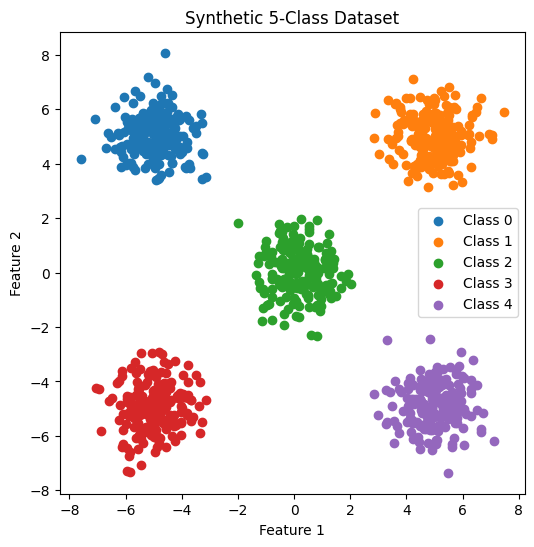

In [100]:
plt.figure(figsize=(6,6))
for class_c in range(num_classes):
    plt.scatter(input_data[labels==class_c,0], input_data[labels==class_c,1], label=f'Class {class_c}')
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

Training Loop with Loss and Accuracy

In [101]:
model = MultiClassNN()
num_epochs = 600
training_loss_history = []
training_accuracy_history = []

for i in range(num_epochs):
    model.train(X_train, Y_train_oh)

    train_predictions_oh = model.forward_pass(X_train)

    # Loss (Mean Squared Error)
    training_loss_history.append(np.mean(np.square(Y_train_oh - train_predictions_oh)))

    # Accuracy
    train_predictions_class = np.argmax(train_predictions_oh, axis=1)
    training_accuracy_history.append(np.mean(train_predictions_class == y_train))

    # Print every 20 epochs
    if (i+1) % 20 == 0:
        print(f"Epoch {i+1}: Loss={training_loss_history[-1]:.4f}, Accuracy={training_accuracy_history[-1]:.4f}")

Epoch 20: Loss=0.1006, Accuracy=0.3912
Epoch 40: Loss=0.0852, Accuracy=0.5938
Epoch 60: Loss=0.0726, Accuracy=0.6138
Epoch 80: Loss=0.0677, Accuracy=0.6238
Epoch 100: Loss=0.0654, Accuracy=0.6300
Epoch 120: Loss=0.0636, Accuracy=0.6475
Epoch 140: Loss=0.0621, Accuracy=0.6562
Epoch 160: Loss=0.0606, Accuracy=0.6575
Epoch 180: Loss=0.0592, Accuracy=0.6650
Epoch 200: Loss=0.0578, Accuracy=0.6787
Epoch 220: Loss=0.0566, Accuracy=0.6863
Epoch 240: Loss=0.0553, Accuracy=0.6900
Epoch 260: Loss=0.0542, Accuracy=0.7000
Epoch 280: Loss=0.0531, Accuracy=0.7063
Epoch 300: Loss=0.0520, Accuracy=0.7175
Epoch 320: Loss=0.0510, Accuracy=0.7375
Epoch 340: Loss=0.0500, Accuracy=0.7538
Epoch 360: Loss=0.0491, Accuracy=0.7950
Epoch 380: Loss=0.0481, Accuracy=0.8225
Epoch 400: Loss=0.0473, Accuracy=0.8438
Epoch 420: Loss=0.0464, Accuracy=0.8800
Epoch 440: Loss=0.0456, Accuracy=0.9050
Epoch 460: Loss=0.0447, Accuracy=0.9237
Epoch 480: Loss=0.0439, Accuracy=0.9300
Epoch 500: Loss=0.0430, Accuracy=0.9363
Epoc

Loss and Accuracy Plot

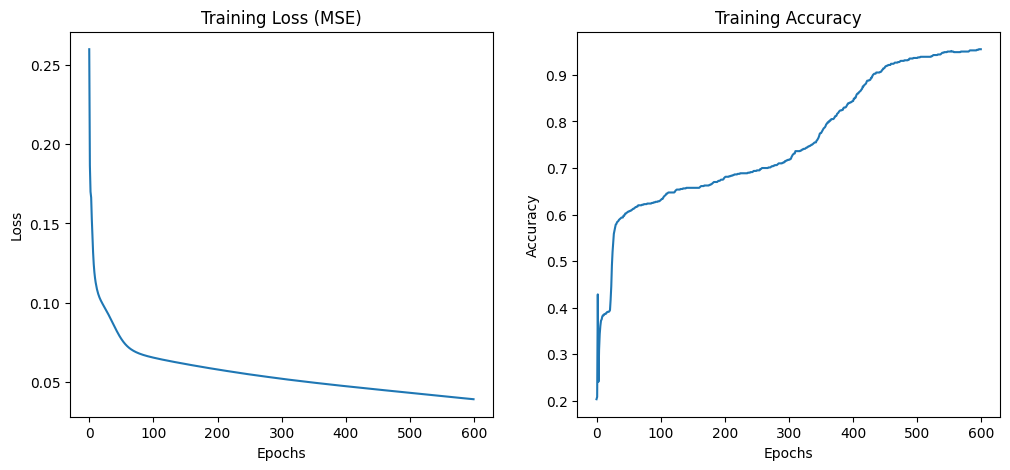

In [102]:
# Loss Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_loss_history)
plt.title("Training Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(training_accuracy_history)
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Model Evaluation on Test Set

In [103]:
test_predictions_class = model.predict(X_test)

# Overall Accuracy
accuracy = np.mean(test_predictions_class == y_test)
print("Test Accuracy:", accuracy)

# Precision, Recall, F1 per class
precision_list, recall_list, f1_list = [], [], []

for class_c in range(num_classes):
    true_positives = np.sum((y_test == class_c) & (test_predictions_class == class_c))
    false_positives = np.sum((y_test != class_c) & (test_predictions_class == class_c))
    false_negatives = np.sum((y_test == class_c) & (test_predictions_class != class_c))

    precision_val = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall_val = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score_val = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

    precision_list.append(precision_val)
    recall_list.append(recall_val)
    f1_list.append(f1_score_val)

for class_c in range(num_classes):
    print(f"Class {class_c}: Precision={precision_list[class_c]:.3f}, Recall={recall_list[class_c]:.3f}, F1-score={f1_list[class_c]:.3f}")

print("Overall Macro F1-score:", np.mean(f1_list))

Test Accuracy: 0.96
Class 0: Precision=0.860, Recall=1.000, F1-score=0.925
Class 1: Precision=0.971, Recall=1.000, F1-score=0.985
Class 2: Precision=1.000, Recall=0.805, F1-score=0.892
Class 3: Precision=0.978, Recall=1.000, F1-score=0.989
Class 4: Precision=1.000, Recall=1.000, F1-score=1.000
Overall Macro F1-score: 0.9581955015537105


Confusion Matrix

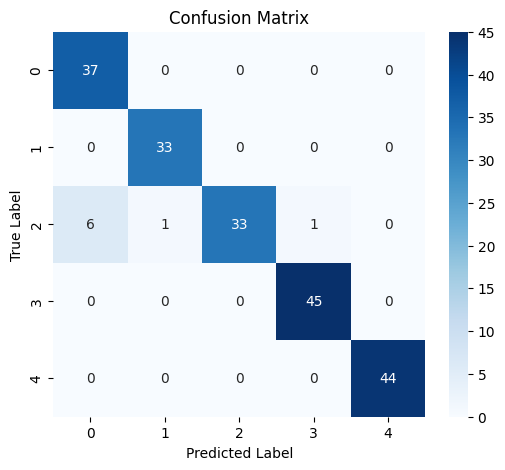

Confusion Matrix (rows=true, columns=predicted):
[[37  0  0  0  0]
 [ 0 33  0  0  0]
 [ 6  1 33  1  0]
 [ 0  0  0 45  0]
 [ 0  0  0  0 44]]


In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, test_predictions_class)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Confusion Matrix (rows=true, columns=predicted):")
print(cm)

Plot Dataset with Predicted Labels

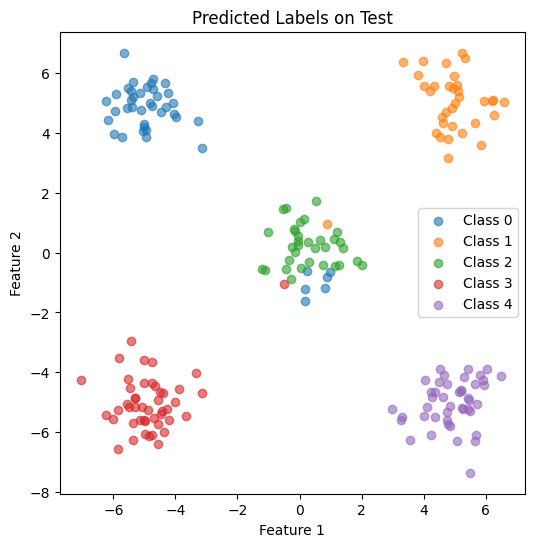

In [105]:
plt.figure(figsize=(6,6))
for class_c in range(num_classes):
    plt.scatter(X_test[test_predictions_class==class_c,0], X_test[test_predictions_class==class_c,1], label=f'Class {class_c}', alpha=0.6)
plt.title("Predicted Labels on Test")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

**Summary of Results:**
The three hidden layers provided a good balance between model complexity and accuracy. Overall, the network performed well on this synthetic dataset with proper hyperparameter tuning.

# Discussion
In this assignment, i have implemented a three hidden layer neural network for multi-class classification on a synthetic dataset with five classes. Using ReLU in hidden layers and softmax in the output layer allowed the network to learn efficiently and handle multiple classes effectively.

The network successfully reduced loss and improved accuracy over training, with evaluation metrics accuracy, precision, recall, and F1-score demonstrating good performance. The confusion matrix confirmed that most samples were correctly classified.

Key challenges included adapting backpropagation for multi-class output and tuning weights and learning rate. Lessons learned highlight the importance of activation functions and proper loss calculation. Future improvements could include larger datasets, different hidden layer sizes, regularization techniques, or advanced optimizers to further enhance performance.